# README
I created this to further develop the algo after encapsulating common data fetching, calculations and plotting functions in a separate module. this will help focus on the algo development and reduce notebook size.

### customising the theme and look of Jupyter notebook
#!jt -l
!jt -t gruvboxd
To restore the default theme of the notebook, run the command line statement as !jt -r

Enable the toolbar: !jt -t [theme name] -T

Enable the filename and logo: !jt -t [theme name] -N

Enable the kernel logo: !jt -t [theme name] -kl

# Overall Objectives
1. Refine the algo 
2. Backtest algo
3. Iterate until I have acceptable performance on BTC
4. Connect with Kraken API 
5. Ability to do basic buy/sell from program
6. Make a real trade from code

<Steps from here one are a bit FUZZY at the moment, will define more as we get closer >

7. Develop code so that algo can calculate signals and make a simplle buy/sell trade at the press of a single button 
8. Improve above code so that it can take into account wallet balance and overall money already invested, loss, stop loss, etc (WILL DEFINE MORE LATER)
8. Allocate 100 dollars in a wallet to be managed automatically 
9. refactor code and deploy so that everything can happen automatically in the cloud (WILL DEFINE LATER in MORE DETAIL)

In [1]:
import pandas as pd
import json 
import matplotlib.pyplot as plt
import seaborn as sns
import random
import datetime as dt
pd.set_option('display.max_columns', None) # so that we can view the pandas dataframes better source link
pd.set_option("display.precision", 2) # https://towardsdatascience.com/pandas-full-tutorial-on-a-single-dataset-4aa43461e1e2

#All necessary plotly libraries
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio

# importing my modules
from cryptotradingalgo import algodevtools as adt

In [20]:
# making notebook wider
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
#set seaborn theme
sns.set_theme(style="white")
sns.set(rc={'figure.figsize':(15,8)})

# fix for amking sure plotly plots dont disappear https://plotly.com/python/troubleshooting/
pio.renderers.default='notebook'

### Fetch prices and calculate signals for BTC and ETH 

In [56]:
# for BTC
btc_hist_prices=adt.get_daily_prices("bitcoin")
adt.create_indicators(btc_hist_prices)
adt.calc_signals(btc_hist_prices)
adt.gen_trades(btc_hist_prices)

# for ETH
eth_hist_prices=adt.get_daily_prices("ethereum")
adt.create_indicators(eth_hist_prices)
adt.calc_signals(eth_hist_prices)
adt.gen_trades(eth_hist_prices)


## Exploring Price and Volatility Signals 

In [53]:
adt.plotly_price_vs_inds (btc_hist_prices,vs_inds=['vol_sma_7', 'vol_sma_30'], num_days=1000) # or inds_on_price?

start date: 2020-10-08 00:00:00 end date: 2023-07-05 00:00:00


In [55]:
adt.plotly_price_vs_inds (btc_hist_prices,vs_inds=['dev_price_7_30', 'dev_vol_7_30'], num_days=1000) # or inds_on_price?

start date: 2020-10-08 00:00:00 end date: 2023-07-05 00:00:00


In [51]:
adt.plotly_price_vs_inds (btc_hist_prices,vs_inds=['price_sma_7', 'price_sma_30'], start_date='2015-07-01', num_days=500) # or inds_on_price?

start date: 2015-07-01 00:00:00 end date: 2016-11-12 00:00:00


In [27]:
adt.plotly_price_vs_inds (btc_hist_prices,vs_inds=['price_sma_30','price_sma_7','price_sma_90'], num_days=1000) # or inds_on_price?

start date: 2020-10-08 00:00:00 end date: 2023-07-05 00:00:00


## Observations

### When about to peak ...
* price_sma_7 going above price_sma_30 is an excellent buy signal
    * HOWEVER, the converse is not true and by the time it goes below 30-day avg again, its usually too late, specially for sharp downtrends
    * It is still good as an addiitonal measure though since it 7 day avg is below 30 day average def sell
        * I will need to find other signals to identify sharp down trends in time 
    
* dev_price_7_30 seems like a great signal for calculating buy signals, go long when it is +ve
    * however, sometimes, its a bit laggy, BUT if we saw that 1. it was negative  ,2. there was a trend reversal and 3. trend reversal has sustained for 3 or more days - then we can buy before it becomes positive 
        * I will need to check the 3-day parameter could be more as well 

* Typically, but NOT always, there is a sharp increase in vol_sma_7 when price is about to peak 
    * This does not always hold and there are peaks when vol_sma_7 does not rise suddenly 
    * This is best used as an additional signal to confirm bull trend rather than rely on its own
        * Its not a good idea to have it as an AND condition, although it may have some other uses since its presence + price action will give higher confidence OR it could be an additional, separate condition to check for BUY signals
    * conversely, if we were to buy each time when VOL suddenly increases BUT PRICE is not going down - then we wont do too badly anyways (BUT we would have missed many entries and made some fivolous trades)
    * the top of the peak from the start of the trend is usually around 7-10, upto 14 days, although, when it does peak sharply, there are huge rises in 2,3 day periods
*  dev vol 7 30 is another indicator we can use to capture the trends in volume
    * in accordance with the above observations, dev vol 7 30 sharply peaks before a price upswing (though not all price spikes have this) and a price drop is preceded with either a shapr increase or decrease in volume coupled with price decrease 
 
#### Does it hold in 2 other random time periods?

### When about to dump ... 
* when price_sma_7 is below price_sma_30 
   * then its definitely time to sell however, OFTEN it is too late of a signal, still useful as an additional check 
* dev price 7 30 did not seem like a reliable indicator of an upcoming sell
* Typically, there are sudden changes in volume when price is about to dump 
    * For vol_sma_7: Either a sudden drop in volume coupled with a price decline (this typically happens right after a peak in volume and a corresponding peak in price) OR a sudden increase in volume coupled with a price decline
    * ~~It seems that 30-day vol being in a uptrend is a bullish indicator and downtrend bearish HOWEVER this is not true for all bull and bear trends, hence this is probably best used as an additional indicator not a sole one ~~ It seems this does not hold always 
    * length of peak (ie. from start to to of the peak, so half) seems to be around 7 days or so 
    * If i sold every time price decreased and one of the above was true, i will be fine 
    * for dev_vol_7_30 , the observations would be similar, however, its better suited for an algo as its relative (but doenst take into account the actual levels)
* IF price dev 7 30 is in a downtrend (say for 2 -3 days its negative) and there is a sudden dev vol 7 30 increase or decrease - then definitely SELL

#### Does it hold in 2 other random time periods?

### False Signals
* 
#### Does it hold in 2 other random time periods?

### A possible Algo 
 
#### Does it hold in 2 other random time periods?

### Notes
#### Long Down and Up trends
* When there is a long gradual increase in 30-day volume, it MIGHT imply that the price is on a long uptrend, no sharp spikes up or down (although there will be some ups and downs in 7 day volume) - **I need to double check this
* Similarly when the overall trend in vol 30 day is downward, then the price is in a long down trend ALTHOUGH there are periods when VOL just goest to a lower level BUT NOT IN a downtred - and price still seems fine, this is possibly more true when VOL increased quite a lot in the first place 
* Note that in both of the above secnarios, there may be temp peaks and troughs, but they dont seem to have any strong pattern with 7 and 30 day vols

#### Recent Trends
* the volumes recently, specially since May are really low i.e. around 10-15B compared a peak of 70B and about 40B around March/April time frame

#### dev vol 7 30 VS vol sma 7 
* they seem to capture similar trends, things are just clearer in dev vol 7 30 - as its relative, so absolulte level increase/decrease does not effect it
    * perhaps if we wanted to know the trends in vol (or other signals) then we will use the vol sma 7, vol sma 30, and such, if we are just looking for patterns to spot a peak, perhaps vol 7 30 is better as m ore sentivie and generalisable 

## Misc Notes
* I should create several simple algo like based on dev price 7 30 , another based solely on vol signals, etc. and backtest them 
* I should create indicators to detect spikes in indicators like volume etc. to make buy/sell decisions, these could later feed into the regression model as well!
* I should creat trailing 3-day, 7-day and 10-day slopes for vol 7, dev vol 7 30, etc. and also add a 3-day price average for price comparisons specially for the sell signal
* I should try and visualise as much of this indicators as possible 
* Perhaps I should calculate signals on a weekly basis? and also calculate for preceding 2, 3 periods - for e..g if tren up for for some time - then its a strong signal, etc. 
* I will check if suing exponetial averages can reduce teh lag in 7, 30 day averages, etc. 

## Ideas on Algo 

### A simple average algos
1. Buy when price is above 30-day average, sell when its below it
2. Buy when 7 day price average is above 30-day average and sell when its below it 

### Another algo based on dev price 7 30 
1. Buy when either dev price 7 30 is above 0 OR changes trend (and sustained for 3 days) to buy and sell when its below 0 again 

### Another algo that has a good sell signal and one of the above for BUY 

sell signal could be 1. dev_price_7_30 is <0 OR 2. price is in sustained downtrend and vol is either in strong down or strong uptrend (both of them for 3 days straight - will impovise later on 3-day parameter)

### Then depending on learnings, LOCK in one of the algos as I need to move to backtesting now 

### Algo 1: Using only 30-day price average 

In [ ]:
def calc_signals_algo1(coin_hist_prices):
    
    coin_hist_prices['signal'] = None 
    
    # Calculate BUY signals
    for index, row in coin_hist_prices.iterrows():
         if ((row['dev_price_7_30_trend'] =='UP') & (row['dev_vol_7_30_trend'] =='UP')):
            coin_hist_prices.at[index,'signal'] ='BUY'
    #      if ((row['dev_price_7_30'] <0)& (row['dev_price_7_30_trend']=='REV_UP')& ((row['dev_vol_7_30_trend']=='REV_UP')|(row['dev_vol_7_30_trend']=='UP'))):
    #          coin_hist_prices.at[index,'signal'] ='BUY'

    # Calculate SELL signals 
    for index, row in coin_hist_prices.iterrows():
        if (row['dev_price_7_30_trend']=='REV_DOWN'):
             coin_hist_prices.at[index,'signal'] ='SELL'
        elif ((row['dev_price_7_30'] <0)& (row['dev_price_7_30_trend']=='DOWN')):
            coin_hist_prices.at[index,'signal'] ='SELL'

    #### HAVe REVISED SELL SIGNAL to add a condition that dev price 7 30 trend != REV_UP to signal a sell when its -ve

In [ ]:
calc_signals_algo1(btc_hist_prices)
adt.gen_trades(btc_hist_prices)

In [ ]:
adt.plotly_signals(btc_hist_prices)

### Algo 2: Only comparing 7-day price with 30-day price

# Scratchpad 

In [8]:
adt.plotly_inds(btc_hist_prices,inds=['price','price_sma_30','price_sma_7'])

start date: 2023-01-06 00:00:00 end date: 2023-07-05 00:00:00
this is the new code


In [ ]:
# Plotting 

### When about to peak ...
* 

#### Does it hold in 2 other random time periods?

### When about to dump ... 
* 
#### Does it hold in 2 other random time periods?

### False Signals
* 
#### Does it hold in 2 other random time periods?

### A possible Algo 
* 
#### Does it hold in 2 other random time periods?

### Notes
*

(**Verify observations on at least 2 other time periods**)

### When about to peak ...
* 

#### Does it hold in 2 other random time periods?

### When about to dump ... 
* 
#### Does it hold in 2 other random time periods?

### False Signals
* 
#### Does it hold in 2 other random time periods?

### A possible Algo 
* 
#### Does it hold in 2 other random time periods?

### Notes
*
(**Verify observations on at least 2 other time periods**)

### Function signatures of plotting functions from cryptoalgotools module

#### Plot an indicator
plot_inds(coin_hist_prices,inds=[],start_date='2001-01-01',end_date='2001-01-01', num_days=180 ):

plotly_inds(coin_hist_prices,inds=[],start_date='2001-01-01',end_date='2001-01-01', num_days=180 ):

#### Plot price vs upto 3 indicators
plot_price_vs_inds (coin_hist_prices,vs_inds=[],start_date='2001-01-01',end_date='2001-01-01', num_days=180,colors=['red','blue','green']): # or inds_on_price?

plotly_price_vs_inds (coin_hist_prices,vs_inds=[],start_date='2001-01-01',end_date='2001-01-01', num_days=180,colors=['red','blue','green']): # or inds_on_price?

#### Plot buy/sell signals as well as inds
plot_signals(coin_hist_prices,inds=[],start_date='2001-01-01',end_date='2001-01-01', num_days=180,colors=['orange','purple','grey'] ):   

plotly_signals (coin_hist_prices,start_date='2001-01-01',end_date='2001-01-01', num_days=180,colors=['red','blue','green']): # or inds_on_price?


In [57]:
adt.plotly_signals(btc_hist_prices)

start date: 2023-01-08 00:00:00 end date: 2023-07-07 00:00:00


start date: 2023-01-06 00:00:00 end date: 2023-07-05 00:00:00


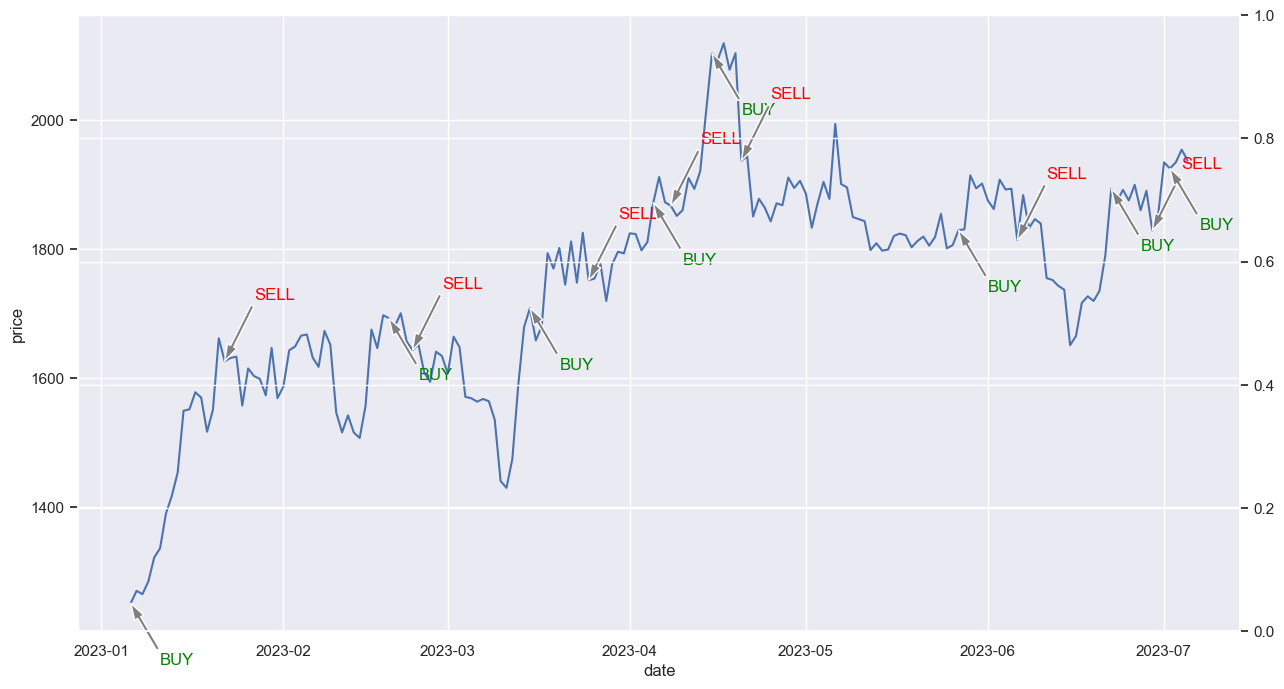

In [10]:
adt.plot_signals(eth_hist_prices)

In [ ]:
btc_hist_prices[['date','price','price_sma_30','dev_price_sma_30','signal', 'trade_reco']].sample(10)

In [ ]:
# Plotting functions 

In [ ]:
# possible calls 
#plot_inds(btc_hist_prices,inds=['price','price_sma_30','price_sma_7'])
#plot_inds(btc_hist_prices,inds=['price','price_sma_30'],start_date='2020-01-01')
#plot_inds(btc_hist_prices,inds=['price','price_sma_30'],start_date='2020-01-01',num_days=500)
#plot_inds(btc_hist_prices,inds=['price','price_sma_30'],start_date='2020-01-01',end_date='2020-09-01')
#plot_inds(btc_hist_prices,inds=['price','price_sma_30'],start_date='2020-01-01')
#plot_inds(btc_hist_prices,inds=['price'],num_days=500)

In [ ]:
#plot_price_vs_inds(btc_hist_prices,vs_inds=['dev_price_sma_7','dev_price_7_30'],colors=['blue','green'])
#plot_price_vs_inds(btc_hist_prices,vs_inds=['dev_price_sma_7','dev_price_7_30'],colors=['blue','green'], num_days=500)
plot_price_vs_inds(btc_hist_prices,vs_inds=['dev_price_sma_7','dev_price_7_30'],start_date='2019-06-09', num_days=200)

In [ ]:
plot_signals(btc_hist_prices)

In [ ]:
plot_signals(btc_hist_prices,inds=['dev_vol_7_30'])

In [ ]:
plotly_inds(btc_hist_prices,inds=['price','price_sma_30'],start_date='2020-01-01',end_date='2020-09-01')


In [ ]:
plotly_price_vs_inds(btc_hist_prices,vs_inds=['dev_price_sma_7','dev_price_7_30'],colors=['blue','green'], num_days=500)

In [ ]:
plotly_price_vs_inds(btc_hist_prices,vs_inds=['dev_price_sma_7','dev_price_7_30'],start_date='2019-06-09', num_days=200)

In [ ]:
plotly_signals(btc_hist_prices,num_days=200)

# To DOs ( July 7 )

1. ~~need to cnifrm above observations (Sell signal)~~
2. ~~then I will confirm buy signal observations~~ 
3. ~~then I will check price sma 7 and dev price sma 7 30 signals~~
4. ~~then i will forumalte ideas on algo~~
5. ~~then move on to other signals~~
